In [11]:
import pandas as pd
from io import StringIO
from sklearn.metrics import f1_score


# Read data from the CSV file and select only the required columns.
filename = 'all_results_RSD_src.csv'

if 'src' in filename:
    out_csv = 'reentrancy_metrics_data_src.csv'
    latex_file = 'latex_table_src.csv'
    aggregated_file = 'aggregated_results_src.csv'
    input
else:
    out_csv = 'reentrancy_metrics_data_bins.csv'
    latex_file = 'latex_table_bins.csv'
    aggregated_file = 'aggregated_results_bins.csv'
df = pd.read_csv(filename)
df = df[['filename', 'basename', 'exit_code', 'toolid', 'findings']]
# print(df)
df['exit_code'] = df['exit_code'].fillna(-1).astype(int)
print(df.shape)
df = df[~df['basename'].str.contains('Human')]
print(df.shape)
if 'src' in filename:
    df = df[df['filename'].str.contains('safe|ree', na=False)]
# print(df)
#print(df.shape)
# A dictionary mapping each tool to the string(s) it produces for a reentrancy finding.
# You can easily update this dictionary as needed. For tools with multiple labels,
# use a comma-separated string, e.g., 'tool_name': 'label1,label2'.
reentrancy_labels = {
    'aderyn': 'Reentrancy',
    'ccc': 'Reentrancy_Vulnerability',
    'confuzzius': 'Reentrancy',
    'conkas': 'Reentrancy', #.sol 0.5
    'ethor-2023': 'insecure',
    #'manticore-0.3.7': 'Reentrancy', # placeholder
    'mythril-0.24.7': 'State_access_after_external_call_SWC_107',
    'oyente+-2acaf2e': 'Re_Entrancy_Vulnerability',
    'oyente+-060ca34':'Re_Entrancy_Vulnerability',
    'sailfish': 'dao',
    'securify': 'DAO_', 
    'securify2': 'Reentrancy', # does not work
    'sfuzz': 'Reentrancy', 
    'slither-0.11.3': 'reentrancy_eth,reentrancy_no_eth',
    #'smartcheck': 'Reentrancy', # never finds any occurrence of reentrancy
    'solhint-6.0.0': 'reentrancy',
    #'ethainter': 'Reentrancy', # does not work
    'vandal': 'ReentrantCall',
    'gpt-oss': 'reentrant',
    'gpt-5-mini': 'reentrant',
    'gpt-5': 'reentrant',
    'gpt-5-nano': 'reentrant'
    }

# 1. Determine the "true" reentrancy label for each file based on its filename.
# 'ree' followed by an optional number indicates a true reentrancy vulnerability.
df['true_reentrancy'] = df['filename'].str.contains(r'ree', case=False)
# df['true_reentrancy'] = df['basename'].str.contains(r'_ree', case=False)
# if df['true_reentrancy'].isnull().any():
#     df['true_reentrancy'] = df['filename'].str.contains(r'_ree', case=False)
# print(df)

# 2. Determine the "predicted" reentrancy label based on the 'findings' column.
# This function will check if any of the tool-specific reentrancy labels are present in the findings.
def get_prediction(row):
    tool_id = row['toolid']
    findings = str(row['findings']) # Convert to string to handle potential NaN values

    # Check if the tool is in our labels dictionary.
    if tool_id in reentrancy_labels:
        # Split the tool's finding string into a list of individual labels.
        tool_findings = [f.strip() for f in reentrancy_labels[tool_id].split(',')]
        
        # Check if any of the tool's labels are present in the findings from the data.
        for label in tool_findings:
            if label in findings:
                return True
    return False

df['predicted_reentrancy'] = df.apply(get_prediction, axis=1)
#print(df['exit_code']==1)


# 3. Calculate metrics for each unique tool and print only the results.
# Analyze only the tools present in the reentrancy_labels dictionary.
tools_to_analyze = reentrancy_labels.keys()
good_tools = []
print("Reentrancy Metrics per Tool:")
print("=" * 30)

print('Tool, Accuracy, Precision, Recall, F1 Score, Errors')
for tool in tools_to_analyze:

    # Filter the DataFrame for the current tool.
    tool_df = df[df['toolid'] == tool]

    n_results = tool_df.shape[0]

    ERRORS = (tool_df['exit_code'] != 0).sum()

    ERRORS2  = tool_df[(tool_df['exit_code'] != 0) & (tool_df['findings'] == '{}')].shape[0]/n_results if n_results >0 else 0
    # Exclude rows where exit_code is not
    # print(tool_df.shape)
    

    #tool_df = tool_df[(tool_df['exit_code'] == '0') | ((tool_df['exit_code'] != 0) & tool_df['findings']!= '{}')]
    
    #print( tool_df['findings'], tool_df['findings']!= '{}')
    #tool_df = tool_df[tool_df['exit_code'] == '0']
    # if tool == 'vandal':
    #     print(tool_df, tool_df.shape)

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).
    TP = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == True)])
    FP = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == True)])
    TN = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == False)])
    FN = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == False)])
    # print(TP, FP, TN, FN)
    
    # Calculate Accuracy, Precision, and Recall.
    # Handle cases where the denominator is zero to avoid errors.
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
    
    # Precision: Out of all positive predictions, how many were correct?
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: Out of all actual positives, how many were correctly predicted?
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate the F1 Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    #f1_score = f1_score(tool_df['true_reentrancy'], tool_df['predicted_reentrancy'], zero_division=0, average = 'weighted')
    if f1_score > 0:
        good_tools.append(tool)
        print(f"{tool}, {accuracy:.2f}, {precision:.2f}, {recall:.2f}, {f1_score:.2f}, {ERRORS2*100:.2f}" )
        # print(f"  Accuracy:  {accuracy*100:.2f}")
        # print(f"  Precision: {precision*100:.2f}")
        # print(f"  Recall:    {recall*100:.2f}")
        # print(f"  F1 Score:  {f1_score*100:.2f}")
        # #print(f"  Errors: {ERRORS}")
        # print(f"  Errors: {ERRORS2*100:.2f}")
        # print("-" * 30)

print(df.shape)
df = df[(df['exit_code'] == 0) | ((df['exit_code'] != 0) & (df['findings'] != '{}'))]
print(df.shape)
# Save the DataFrame to a new CSV file.
filtered_df = df[df['toolid'].isin(good_tools)]
filtered_df.to_csv(out_csv, index=False)
print(f"\nSaved CSV with only tools that found something → {out_csv}")

(2310, 5)
(2145, 5)
Reentrancy Metrics per Tool:
Tool, Accuracy, Precision, Recall, F1 Score, Errors
aderyn, 0.66, 0.62, 0.79, 0.70, 0.00
ccc, 0.58, 0.74, 0.24, 0.36, 0.00
confuzzius, 0.58, 0.57, 0.61, 0.59, 12.59
mythril-0.24.7, 0.67, 0.67, 0.66, 0.67, 0.00
oyente+-060ca34, 0.60, 0.72, 0.32, 0.45, 0.00
slither-0.11.3, 0.74, 0.71, 0.82, 0.76, 0.00
solhint-6.0.0, 0.55, 0.59, 0.28, 0.38, 0.00
(2145, 7)
(1692, 7)

Saved CSV with only tools that found something → reentrancy_metrics_data_src.csv


In [56]:
filtered_df

,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy
0,safe/01dd4a2eacf1f751bcf9070bca20c3a2_cgt.sol,01dd4a2eacf1f751bcf9070bca20c3a2_cgt.sol,0,ccc,{Reentrancy_Vulnerability},False,True
1,safe/04045504816e9b4137a6838c8a53dde4_cgt.sol,04045504816e9b4137a6838c8a53dde4_cgt.sol,0,ccc,{},False,False
2,safe/083e60356eeecf6edf0e82b79f66a4ba_cgt.sol,083e60356eeecf6edf0e82b79f66a4ba_cgt.sol,0,ccc,{A_miner_can_use_others_input_to_gain_a_benefi...,False,False
3,safe/0a7dcd7ad58d91e0373b21e4e4522cdf_cgt.sol,0a7dcd7ad58d91e0373b21e4e4522cdf_cgt.sol,0,ccc,{Result_of_expression_can_be_over_or_under_flo...,False,False
4,safe/0bf0ebe31b1e67618bc28a9d3738a2e4.sol,0bf0ebe31b1e67618bc28a9d3738a2e4.sol,0,ccc,{Missing_Check_of_Return_Value_from_external_C...,False,False
...,...,...,...,...,...,...,...
5626,safe/ec7ad4af1fc95654260069e7932dbf3d_cgt.sol,ec7ad4af1fc95654260069e7932dbf3d_cgt.sol,-1,sailfish,NaN,False,False
5627,safe/eebbd1de0bd005402b5dde75513c45f6_cgt.sol,eebbd1de0bd005402b5dde75513c45f6_cgt.sol,-1,sailfish,NaN,False,False
5628,safe/eeec1e8a9be3b58748c8e9f28342e429_cgt.sol,eeec1e8a9be3b58748c8e9f28342e429_cgt.sol,-1,sailfish,NaN,False,False
5629,safe/f21a824407dfb37c81f7fbbd8d8e0e58_cgt.sol,f21a824407dfb37c81f7fbbd8d8e0e58_cgt.sol,-1,sailfish,NaN,False,False


In [101]:
import pandas as pd

df = df_re.copy()

# Group predictions per contract
grouped = df.groupby("basename")

# Find the ones where true_reentrancy is True
true_re = grouped.first()
true_re = true_re[true_re["true_reentrancy"] == True]

# Count correct detections per contract
# A correct detection = predicted_reentrancy == true_reentrancy == True
correct_count = grouped["predicted_reentrancy"].sum()

# Keep only contracts where exactly N tool detects TRUE
hard_cases = correct_count[(correct_count == 8)]

# Get the rows from df for these contracts to inspect
results = df[df["basename"].isin(hard_cases.index)]

print(f"Contracts with TRUE reentrancy where only ONE tool is correct: {len(hard_cases)}")

results.sort_values(["basename", "toolid"])


Contracts with TRUE reentrancy where only ONE tool is correct: 11


,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy,loc
63,reentrant/0x2a98d8fc14b31b346ff6c56dc2a252c434...,0x2a98d8fc14b31b346ff6c56dc2a252c434f628f2_rs.sol,0,ccc,{A_miner_can_use_others_input_to_gain_a_benefi...,True,True,14
388,reentrant/0x2a98d8fc14b31b346ff6c56dc2a252c434...,0x2a98d8fc14b31b346ff6c56dc2a252c434f628f2_rs.sol,0,confuzzius,"{Assertion_Failure,Reentrancy,Transaction_Orde...",True,True,14
752,reentrant/0x2a98d8fc14b31b346ff6c56dc2a252c434...,0x2a98d8fc14b31b346ff6c56dc2a252c434f628f2_rs.sol,0,conkas,"{Reentrancy,Transaction_Ordering_Dependence}",True,True,14
1066,reentrant/0x2a98d8fc14b31b346ff6c56dc2a252c434...,0x2a98d8fc14b31b346ff6c56dc2a252c434f628f2_rs.sol,1,mythril-0.24.7,"{Exception_State_SWC_110,External_Call_To_User...",True,True,14
1363,reentrant/0x2a98d8fc14b31b346ff6c56dc2a252c434...,0x2a98d8fc14b31b346ff6c56dc2a252c434f628f2_rs.sol,1,oyente+-060ca34,{Re_Entrancy_Vulnerability},True,True,14
...,...,...,...,...,...,...,...,...
3064,reentrant/db51cfe3fb4a3646a38c5b5f6e018685_cgt...,db51cfe3fb4a3646a38c5b5f6e018685_cgt.sol,-1,sailfish,"[""dao"", ""tod_transfer""]",True,True,41
1851,reentrant/db51cfe3fb4a3646a38c5b5f6e018685_cgt...,db51cfe3fb4a3646a38c5b5f6e018685_cgt.sol,137,securify,"{DAO_,MissingInputValidation}",True,True,41
2082,reentrant/db51cfe3fb4a3646a38c5b5f6e018685_cgt...,db51cfe3fb4a3646a38c5b5f6e018685_cgt.sol,0,sfuzz,"{Exception_Disorder,Integer_Underflow,Reentran...",True,True,41
2509,reentrant/db51cfe3fb4a3646a38c5b5f6e018685_cgt...,db51cfe3fb4a3646a38c5b5f6e018685_cgt.sol,255,slither-0.11.3,"{constable_states,controlled_array_length,exte...",True,True,41


In [20]:

# Load data
df_loc = pd.read_csv("contracts_loc.csv")
df_re = pd.read_csv(out_csv)

# Remove version from names and capitalize
df_re["toolid"] = df_re["toolid"].str.split("-").str[0].str.capitalize()



# Normalize strings
df_loc["contract_name"] = df_loc["contract_name"].str.strip()
df_re["basename"] = df_re["basename"].str.strip()

# Create a lookup dictionary: {contract_name: loc}
loc_map = dict(zip(df_loc["contract_name"], df_loc["loc"]))

# Add the LOC column based on basename
df_re["loc"] = df_re["basename"].map(loc_map)

# Show rows that did NOT find a match
missing = df_re[df_re["loc"].isna()]["basename"].unique()
print(f"Contracts with NO LOC match: {len(missing)}")
for m in missing:
    print(" -", m)

df_re


Contracts with NO LOC match: 79
 - 00_BasicInline_ree1.sol
 - 00_BasicInline_safe1.sol
 - 01_SingleMutexFoldUnderflow_ree1.sol
 - 01_SingleMutexFoldUnderflow_safe1.sol
 - 02_CrossMutexUnderflow_ree1.sol
 - 02_CrossMutexUnderflow_safe1.sol
 - 03_SingleModFoldUnderflow_ree1.sol
 - 03_SingleModFoldUnderflow_safe1.sol
 - 03_SingleModUnderflow_ree1.sol
 - 03_SingleModUnderflow_safe1.sol
 - 04_CrossModFoldUnderflow_safe1.sol
 - 05_SendEmitUnchecked_safe1.sol
 - 05_SendEmit_safe1.sol
 - 05_SendUnchecked_safe1.sol
 - 05_Send_safe1.sol
 - 05_Send_safe2.sol
 - 05_Send_safe3.sol
 - 06_TransferUnchecked_safe1.sol
 - 06_TransferUnchecked_safe2.sol
 - 06_Transfer_safe1.sol
 - 06_Transfer_safe2.sol
 - 07_MixedSendFoldEmit_ree1.sol
 - 07_MixedSendFoldEmit_safe1.sol
 - 07_MixedSendFold_ree1.sol
 - 07_MixedSendFold_safe1.sol
 - 07_MixedSend_ree1.sol
 - 07_MixedSend_safe1.sol
 - 08_MixedTransferEmit_ree1.sol
 - 08_MixedTransferEmit_safe1.sol
 - 08_MixedTransfer_ree1.sol
 - 08_MixedTransfer_safe1.sol
 - 0

,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy,loc
0,src/00_BasicCall_ree1.sol,00_BasicCall_ree1.sol,0,Ccc,{},True,False,14.0
1,src/00_BasicCall_safe1.sol,00_BasicCall_safe1.sol,0,Ccc,{},False,False,14.0
2,src/00_BasicConst_ree1.sol,00_BasicConst_ree1.sol,0,Ccc,{},True,False,15.0
3,src/00_BasicConst_safe1.sol,00_BasicConst_safe1.sol,0,Ccc,{},False,False,15.0
4,src/00_BasicCross_ree1.sol,00_BasicCross_ree1.sol,0,Ccc,{Message_padding_vulnerability_found_at_ether_...,True,False,19.0
...,...,...,...,...,...,...,...,...
978,src/15_ReadOnlyStaticcall_ree1.sol,15_ReadOnlyStaticcall_ree1.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN
979,src/15_ReadOnlyStaticcall_safe1.sol,15_ReadOnlyStaticcall_safe1.sol,0,Aderyn,[],False,False,NaN
980,src/15_ReadOnly_ree1.sol,15_ReadOnly_ree1.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN
981,src/15_ReadOnly_ree2.sol,15_ReadOnly_ree2.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN


In [58]:
# # 1. seleziono solo i contratti davvero reentrant
# df_true = df_re[df_re["true_reentrancy"] == True]

# # 2. per ogni contratto, verifico se almeno un tool lo ha beccato
# grouped = df_true.groupby("basename")["predicted_reentrancy"].any()

# # 3. contratti reentranti NON rilevati da nessun tool
# undetected = grouped[grouped == False].index.tolist()

# print("Reentrant contracts NOT detected by any tool:", len(undetected))
# for u in undetected:
#     print(" -", u)


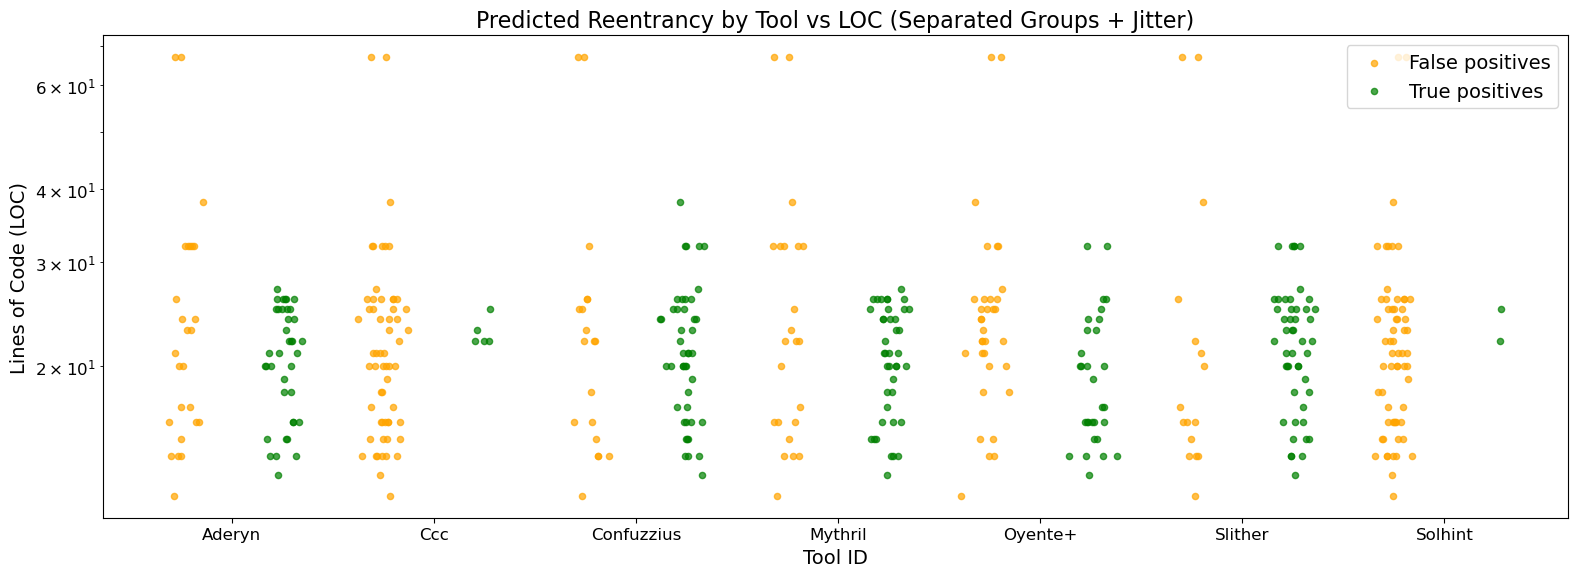

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# df_re must contain: toolid, loc, predicted_reentrancy

plt.figure(figsize=(16, 6))

tools = sorted(df_re["toolid"].unique())

# For each tool we create two x positions:
# left cluster  = predicted False
# right cluster = predicted True
x_base = {tool: i for i, tool in enumerate(tools)}

# width of separation between the two groups per tool
offset = 0.25

for tool in tools:
    subset = df_re[df_re["toolid"] == tool]
    base = x_base[tool]

    # FALSE group (orange)
    false_group = subset[subset["predicted_reentrancy"] == False]
    x_false = np.full(len(false_group), base - offset)
    x_false_jitter = x_false + np.random.normal(0, 0.05, size=len(false_group))

    plt.scatter(
        x_false_jitter,
        false_group["loc"],
        c="orange",
        s=20,
        alpha=0.7,
        label="False positives" if tool == tools[0] else None
    )

    # TRUE group (green)
    true_group = subset[subset["predicted_reentrancy"] == True]
    x_true = np.full(len(true_group), base + offset)
    x_true_jitter = x_true + np.random.normal(0, 0.05, size=len(true_group))

    plt.scatter(
        x_true_jitter,
        true_group["loc"],
        c="green",
        s=20,
        alpha=0.7,
        label="True positives" if tool == tools[0] else None
    )

# X-axis tick labels centered between groups
plt.xticks(range(len(tools)), tools)
plt.yscale("log")

plt.xlabel("Tool ID")
plt.ylabel("Lines of Code (LOC)")
plt.title("Predicted Reentrancy by Tool vs LOC (Separated Groups + Jitter)")
plt.legend()
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()


In [23]:
df

,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy,loc
0,src/00_BasicCall_ree1.sol,00_BasicCall_ree1.sol,0,Ccc,{},True,False,14.0
1,src/00_BasicCall_safe1.sol,00_BasicCall_safe1.sol,0,Ccc,{},False,False,14.0
2,src/00_BasicConst_ree1.sol,00_BasicConst_ree1.sol,0,Ccc,{},True,False,15.0
3,src/00_BasicConst_safe1.sol,00_BasicConst_safe1.sol,0,Ccc,{},False,False,15.0
4,src/00_BasicCross_ree1.sol,00_BasicCross_ree1.sol,0,Ccc,{Message_padding_vulnerability_found_at_ether_...,True,False,19.0
...,...,...,...,...,...,...,...,...
978,src/15_ReadOnlyStaticcall_ree1.sol,15_ReadOnlyStaticcall_ree1.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN
979,src/15_ReadOnlyStaticcall_safe1.sol,15_ReadOnlyStaticcall_safe1.sol,0,Aderyn,[],False,False,NaN
980,src/15_ReadOnly_ree1.sol,15_ReadOnly_ree1.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN
981,src/15_ReadOnly_ree2.sol,15_ReadOnly_ree2.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN


/var/folders/wm/j8718kpn1fxf8b0tct1fkykr0000gn/T/ipykernel_49397/1629308966.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_points))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values

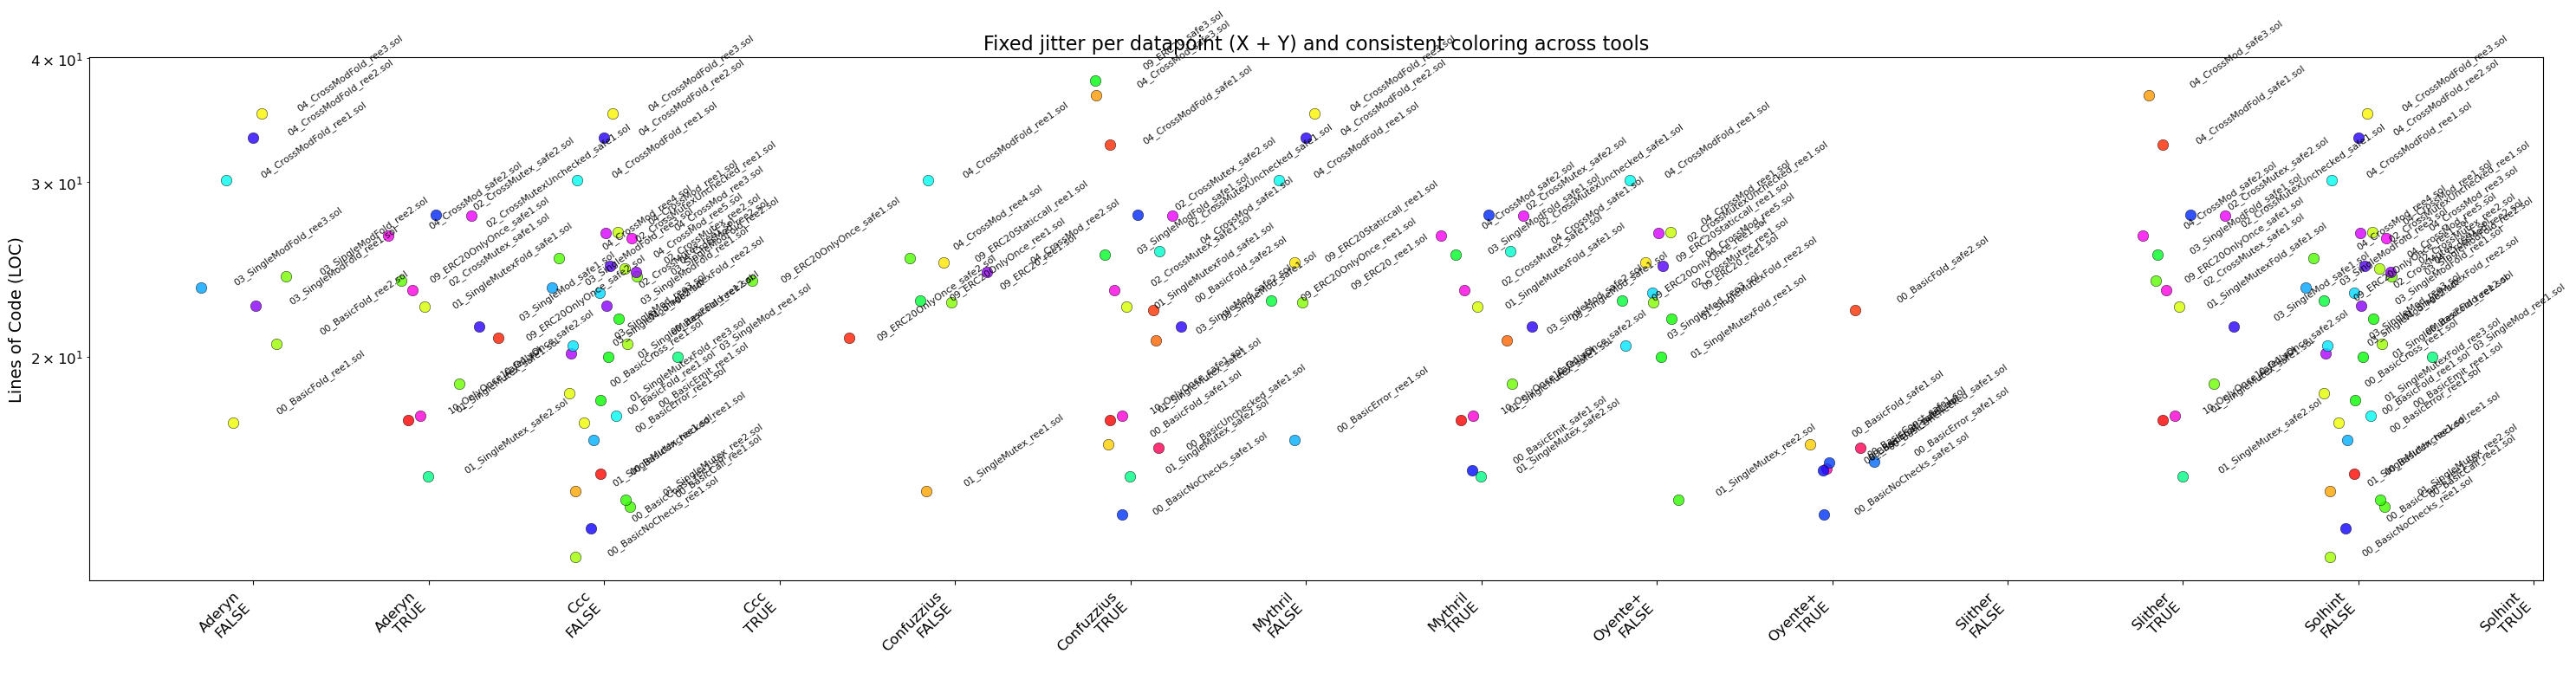

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors



df = df_re.copy()

# ----------------------------------------------------
# 1. Assign UNIQUE COLOR + UNIQUE X-JITTER + UNIQUE Y-JITTER to each datapoint
# ----------------------------------------------------
unique_points = df["basename"].unique()
n = len(unique_points)
cmap = cm.get_cmap('tab20', len(unique_points))
colors = {}
x_jitter = {}
y_jitter = {}

np.random.seed(42)
np.random.shuffle(unique_points)  # <-- THIS changes color ordering

for i, name in enumerate(unique_points):
    # evenly spaced colors on the HSV color wheel
    hue = i / n
    colors[name] = plt.cm.hsv(hue)[:3]  # convert to RGB

    x_jitter[name] = np.random.normal(0, 0.15)
    y_jitter[name] = np.random.normal(0, 0.05)

# ----------------------------------------------------
# 2. Build X-axis groups: tool_FALSE, tool_TRUE
# ----------------------------------------------------
tools = sorted(df["toolid"].unique())

x_labels = []
x_positions = {}
pos = 0

for tool in tools:
    x_positions[(tool, False)] = pos
    x_labels.append(f"{tool}\nFALSE")
    pos += 1
    
    x_positions[(tool, True)] = pos
    x_labels.append(f"{tool}\nTRUE")
    pos += 1

# ----------------------------------------------------
# 3. PLOT — fixed jitter X + fixed jitter Y
# ----------------------------------------------------
plt.figure(figsize=(30, 8))

for _, row in df.iterrows():
    label = row['true_reentrancy']
    name = row["basename"]
    tool = row["toolid"]
    loc = row["loc"]
    pred = row["predicted_reentrancy"]

    if label != pred:
        # FIXED jitter per datapoint
        x = x_positions[(tool, pred)] + x_jitter[name]
        y = loc + y_jitter[name] * loc  # keep jitter proportional but linear


        plt.scatter(
            x,
            y,
            c=[colors[name]],
            s=80,
            alpha=0.8,
            edgecolor="black",
            linewidth=0.4
        )
        plt.text(
            x+0.5,
            y * 1.1,   # 1.5% above the ball
            name,
            fontsize=8,
            ha='center',
            va='center',
            alpha=0.9,
            rotation=35
        )


# ----------------------------------------------------
# 4. Formatting
# ----------------------------------------------------
plt.yscale("log")
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
plt.ylabel("Lines of Code (LOC)")
plt.title("Fixed jitter per datapoint (X + Y) and consistent coloring across tools")



plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

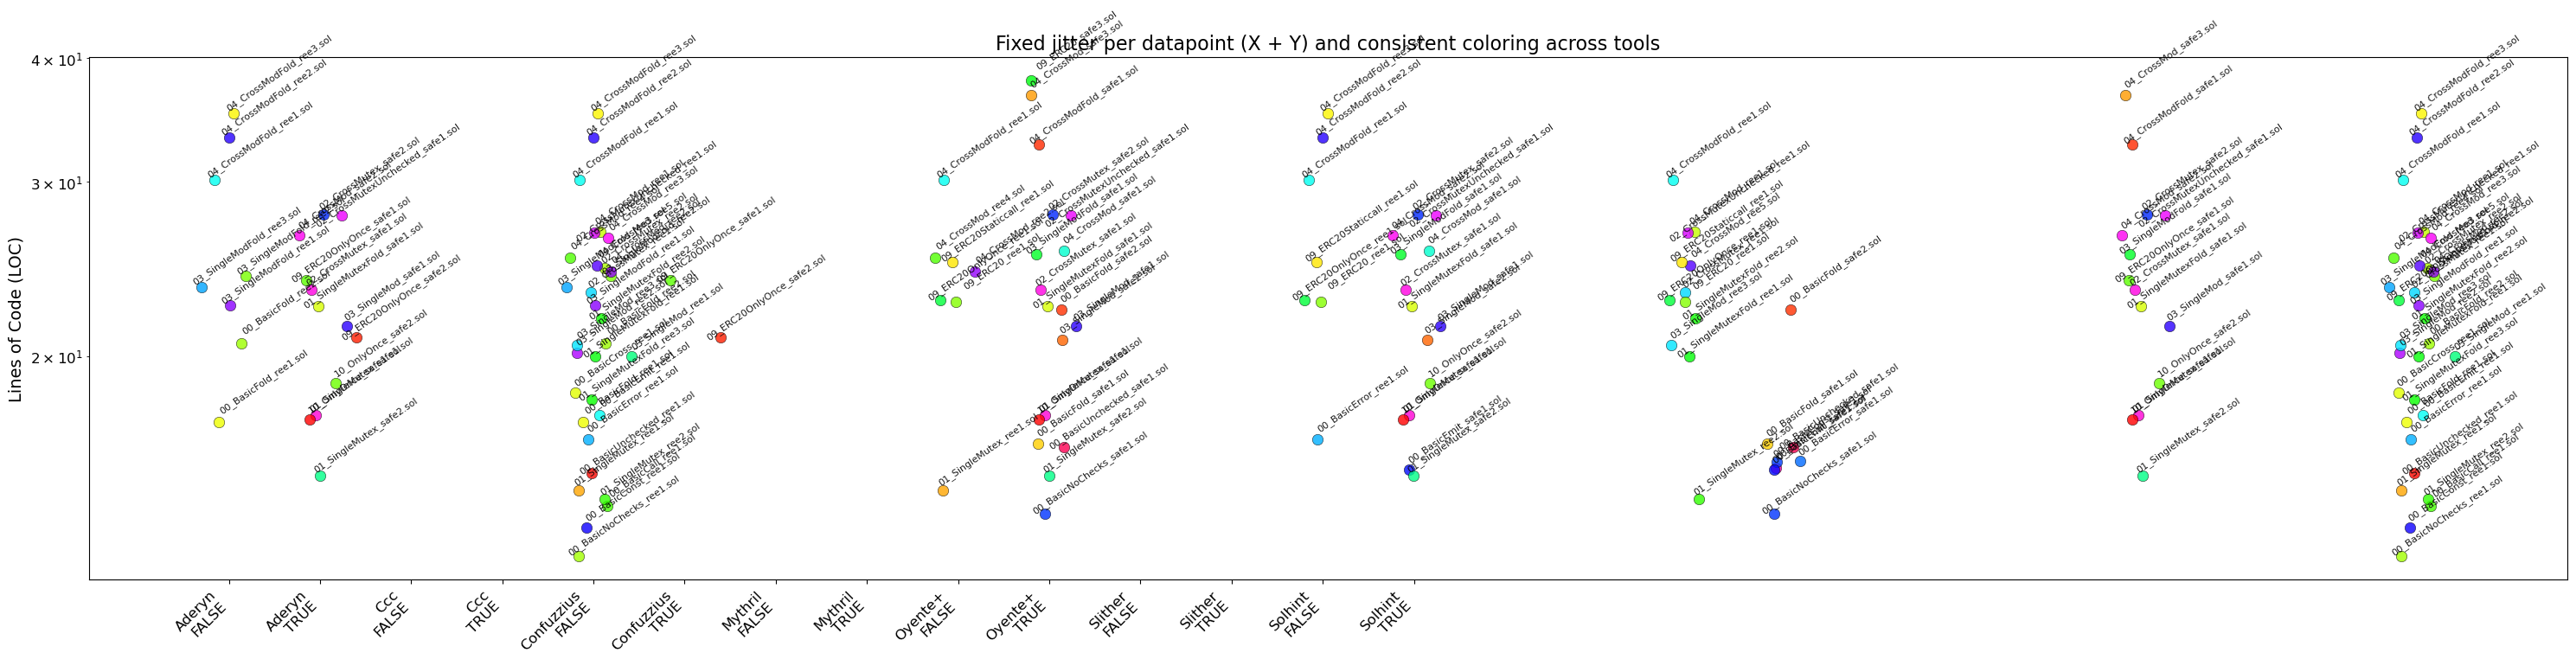

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

df = df_re.copy()

# ----------------------------------------------------
# 1. Assign UNIQUE COLOR + UNIQUE X-JITTER + UNIQUE Y-JITTER to each datapoint
# ----------------------------------------------------
unique_points = df["basename"].unique()
n = len(unique_points)
colors = {}
x_jitter = {}
y_jitter = {}

np.random.seed(42)
np.random.shuffle(unique_points)  # <-- ensures colors unrelated to position

for i, name in enumerate(unique_points):
    hue = i / n
    colors[name] = plt.cm.hsv(hue)[:3]

    x_jitter[name] = np.random.normal(0, 0.15)
    y_jitter[name] = np.random.normal(0, 0.05)

# ----------------------------------------------------
# 2. Build X-axis groups: tool_FALSE, tool_TRUE
# ----------------------------------------------------
tools = sorted(df["toolid"].unique())

group_spacing = 2     # <---- MODIFY THIS to increase horizontal separation
pos = 0
x_positions = {}
x_labels = []

for tool in tools:
    # FALSE group
    x_positions[(tool, False)] = pos
    x_labels.append(f"{tool}\nFALSE")
    pos += 1

    # TRUE group
    x_positions[(tool, True)] = pos
    x_labels.append(f"{tool}\nTRUE")
    pos += 1

    # ADD SPACING BETWEEN TOOLS
    pos += group_spacing

# ----------------------------------------------------
# 3. PLOT — fixed jitter X + fixed jitter Y
# ----------------------------------------------------
plt.figure(figsize=(max(30, len(tools) * 3), 8))

for _, row in df.iterrows():
    label = row['true_reentrancy']
    name = row["basename"]
    tool = row["toolid"]
    loc = row["loc"]
    pred = row["predicted_reentrancy"]

    if label != pred:
        x = x_positions[(tool, pred)] + x_jitter[name]
        y = loc + y_jitter[name] * loc

        plt.scatter(
            x,
            y,
            c=[colors[name]],
            s=80,
            alpha=0.8,
            edgecolor="black",
            linewidth=0.4
        )

        plt.text(
            x + 0.5,
            y * 1.10,
            name,
            fontsize=8,
            ha='center',
            va='center',
            alpha=0.9,
            rotation=35
        )

# ----------------------------------------------------
# 4. Formatting
# ----------------------------------------------------
plt.yscale("log")
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')

plt.ylabel("Lines of Code (LOC)")
plt.title("Fixed jitter per datapoint (X + Y) and consistent coloring across tools")

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig("misclassified.pdf", bbox_inches="tight")
plt.show()


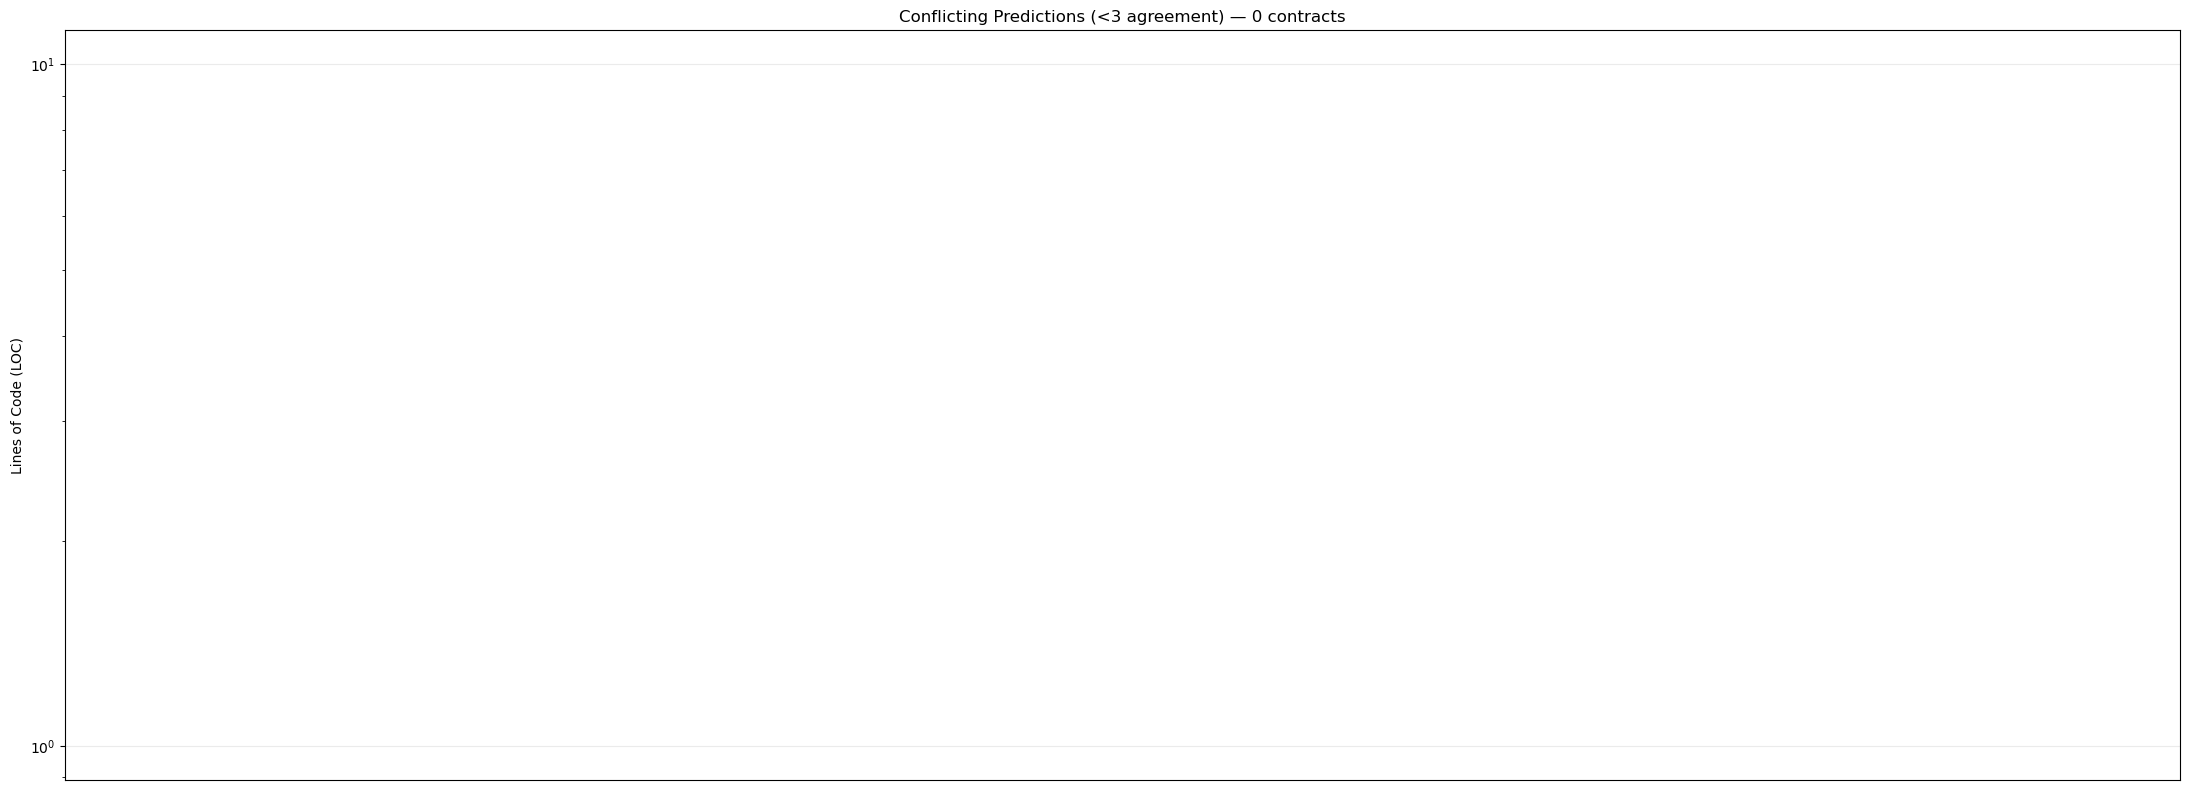

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import colorsys

df = df_re.copy()

# =========================================
# 1️⃣ FILTER: keep basenames where < 3 tools agree
# =========================================
agreement = df.groupby("basename")["predicted_reentrancy"].agg(["sum", "count"])
agreement["false"] = agreement["count"] - agreement["sum"]

filtered_names = agreement[(agreement["sum"] > 3) & (agreement["false"] > 3)].index

df_plot = df[df["basename"].isin(filtered_names)].copy()

# =========================================
# 2️⃣ Assign strong shuffled colors per basename
# =========================================
unique_points = df_plot["basename"].unique()
n = len(unique_points)

np.random.seed(42)
np.random.shuffle(unique_points)  # so neighbors don't share colors

colors = {}
x_jitter = {}
y_jitter = {}

for i, name in enumerate(unique_points):
    hue = i / n
    r, g, b = colorsys.hsv_to_rgb(hue, 0.88, 0.85)
    colors[name] = (r, g, b)

    x_jitter[name] = np.random.normal(0, 0.15)
    y_jitter[name] = np.random.normal(0, 0.015)

# =========================================
# 3️⃣ Build X-axis grouped by tool + pred
# =========================================
tools = sorted(df_plot["toolid"].unique())
x_labels = []
x_positions = {}
pos = 0

for tool in tools:
    for pred in [False, True]:
        x_positions[(tool, pred)] = pos
        x_labels.append(f"{tool}\n{pred}")
        pos += 1

# =========================================
# 4️⃣ Plot
# =========================================
plt.figure(figsize=(22, 8))

for _, row in df_plot.iterrows():
    basename = row["basename"]
    tool = row["toolid"]
    loc = row["loc"]
    pred = row["predicted_reentrancy"]

    x = x_positions[(tool, pred)] + x_jitter[basename]
    y = loc + y_jitter[basename] * loc

    plt.scatter(
        x,
        y,
        c=[colors[basename]],
        s=90,
        alpha=0.92,
        edgecolor="black",
        linewidth=0.5,
    )

    # Label the point
    plt.text(
        x,
        y * 1.02,        # tiny vertical offset above marker
        basename,
        fontsize=7,
        ha='center',
        va='bottom',
        alpha=1.0
    )

# =========================================
# 5️⃣ Formatting
# =========================================
plt.yscale("log")
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
plt.ylabel("Lines of Code (LOC)")
plt.title(f"Conflicting Predictions (<3 agreement) — {len(unique_points)} contracts")

plt.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.show()


/var/folders/wm/j8718kpn1fxf8b0tct1fkykr0000gn/T/ipykernel_49397/3758023391.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = pivot.fillna(False).astype(bool)
/opt/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].filln

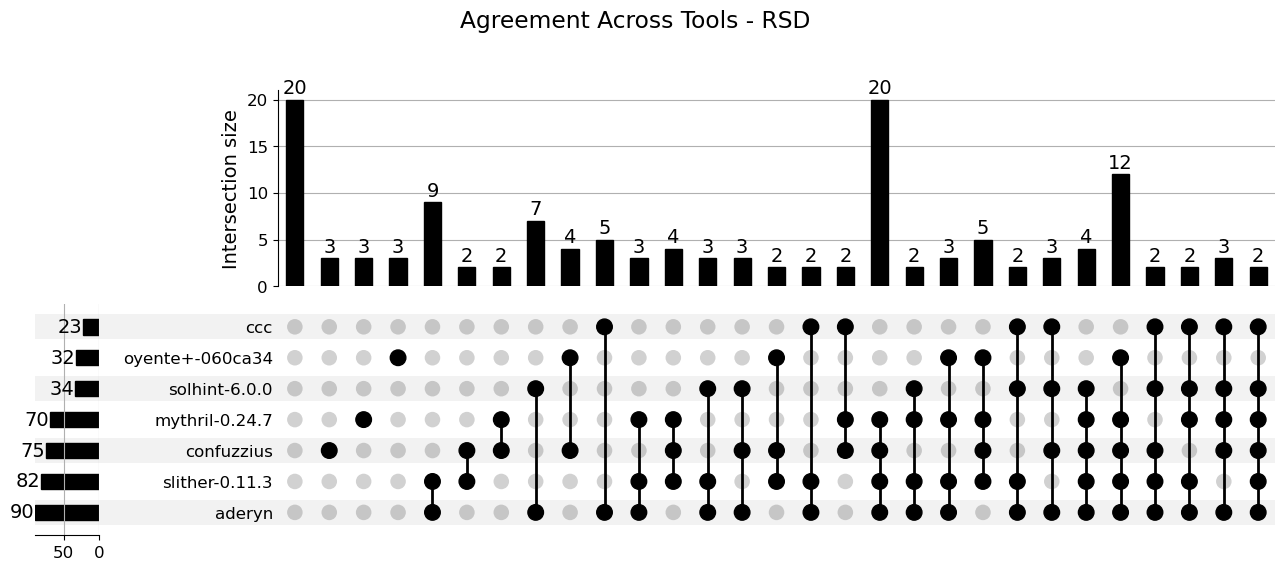

In [14]:
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators


pivot = df.pivot_table(
    index="basename",
    columns="toolid",
    values="predicted_reentrancy",
    aggfunc="first"
)

pivot = pivot.fillna(False).astype(bool)
upset_data = from_indicators(pivot)

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

fig = plt.figure(figsize=(20, 8))

u = UpSet(
    upset_data,
    subset_size="count",
    # orientation="vertical",   # <--- VERTICAL (important)
    show_counts=True,
    #sort_by='cardinality',
    # element_size=40,
    min_subset_size=2
    
)

u.plot(fig=fig)

# add title AFTER plot
fig.suptitle("Agreement Across Tools - RSD", y=1.02)

# Adjust top margin so title stays outside
# fig.subplots_adjust(top=0.998)

fig.savefig("upset_plot_RSD.pdf", bbox_inches="tight")
plt.show()


C:\Users\ressi\AppData\Local\Temp\ipykernel_10444\3212772546.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False).astype(bool)
C:\Users\ressi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\upsetplot\data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
C:\Users\ressi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\upsetplot\plotting.py:795: FutureWarning

<Figure size 1400x1000 with 0 Axes>

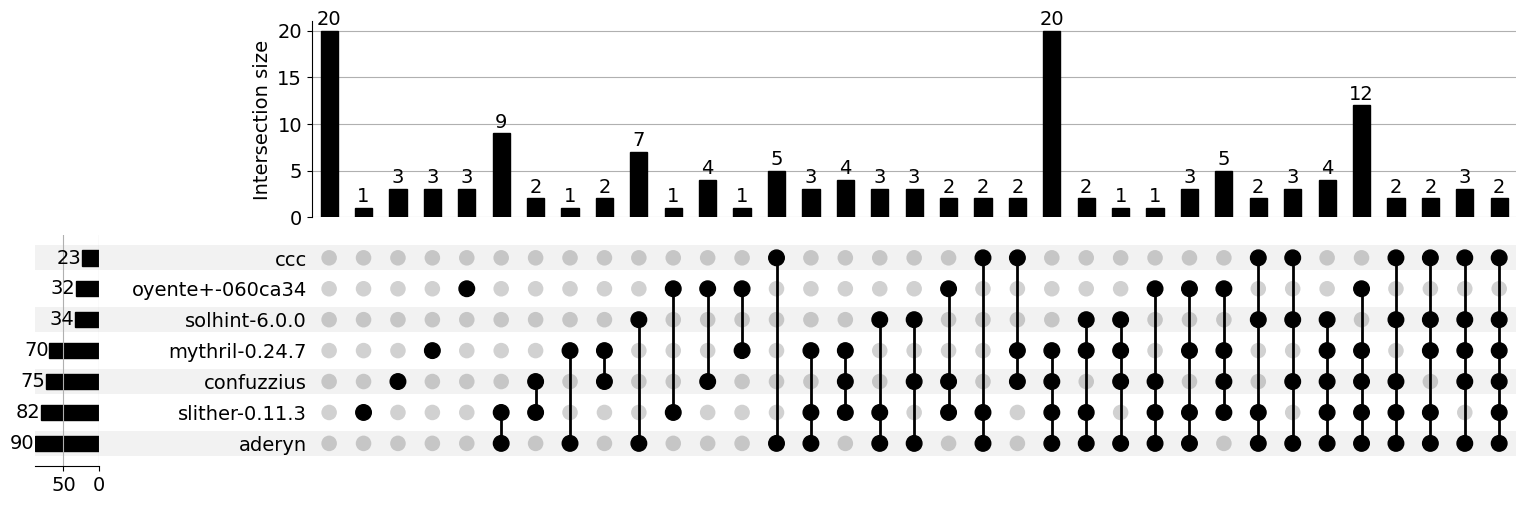

In [ ]:
from upsetplot import UpSet, from_memberships

# pivot: righe = basename, colonne = toolid, valori=True/False
pivot = df.pivot_table(
    index="basename",
    columns="toolid",
    values="predicted_reentrancy",
    aggfunc="first"
).fillna(False).astype(bool)

memberships = []
for basename, row in pivot.iterrows():
    tools_true = [tool for tool, pred in row.items() if pred]
    memberships.append(tools_true)   # <<-- includes empty lists for undetected

data = from_memberships(memberships, data=list(pivot.index))

plt.figure(figsize=(14, 10))
UpSet(data, subset_size="count", show_counts=True).plot()
plt.show()



In [ ]:
df_re

,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy,loc
0,mytests/aggregated-benchmark/src/safe/01dd4a2e...,01dd4a2eacf1f751bcf9070bca20c3a2_cgt.sol,0,ccc,{Reentrancy_Vulnerability},False,True,153
1,mytests/aggregated-benchmark/src/safe/04045504...,04045504816e9b4137a6838c8a53dde4_cgt.sol,0,ccc,{},False,False,28
2,mytests/aggregated-benchmark/src/safe/083e6035...,083e60356eeecf6edf0e82b79f66a4ba_cgt.sol,0,ccc,{A_miner_can_use_others_input_to_gain_a_benefi...,False,False,155
3,mytests/aggregated-benchmark/src/safe/0a7dcd7a...,0a7dcd7ad58d91e0373b21e4e4522cdf_cgt.sol,0,ccc,{Result_of_expression_can_be_over_or_under_flo...,False,False,15
4,mytests/aggregated-benchmark/src/safe/0bf0ebe3...,0bf0ebe31b1e67618bc28a9d3738a2e4.sol,0,ccc,{Missing_Check_of_Return_Value_from_external_C...,False,False,18
...,...,...,...,...,...,...,...,...
2946,mytests/aggregated-benchmark/src/safe/f21a8244...,f21a824407dfb37c81f7fbbd8d8e0e58_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,avoid_...",False,False,364
2947,mytests/aggregated-benchmark/src/reentrant/f26...,f26ed098ddfa730dd9cebaaaab1bceac_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,False,24
2948,mytests/aggregated-benchmark/src/safe/f40afd3f...,f40afd3fefac7bcb1b05c424d48579a7_cgt.sol,1,solhint-6.0.0,"{avoid_throw,compiler_version,const_name_snake...",False,False,98
2949,mytests/aggregated-benchmark/src/reentrant/f73...,f73768e16680cd9fffd24f529e8a6083_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,True,342
